<a href="https://colab.research.google.com/github/l-e13/labs/blob/main/pcahomework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams. Some of these scam e-mails have some offensive content. I don't think anything is worse than R-rated, but I just want to warn you that if you start reading the e-mail text, you might read something offensive. If that's a problem, feel free to e-mail me and we can talk about it more or you can skip the assignment.  

### Q1.

Open the `Phishing_Email.parquet` data. It is available at `https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet`, and you can download it directly using Pandas by providing that URL: `df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')`.

We just want to look at the first step of cleaning text data, so you can get an idea of how it works. The `Email Text` variable contains the actual text of the email and the `Email Type` takes the value `Phishing Email` or `Safe Email`. We want to predict which emails are phishing emails from their contents.

Use the `str.split()` method to break the `Phishing Email` values into **tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens. Print the results of your split and examine it.

In words, how would you clean the tokens and use them to predict whether the email is a phishing scam or not? A short summary of the kinds of tasks you would do and how you would run a predictive algorithm is fine.

In [2]:
import pandas as pd
import numpy as np

df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')
df.head()


,index,Unnamed: 0,Email Text,Email Type
0,0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [3]:
token = df["Email Text"].str.split()
token.head()

,Email Text
0,"[re, :, 6, ., 1100, ,, disc, :, uniformitarian..."
1,"[the, other, side, of, *, galicismos, *, *, ga..."
2,"[re, :, equistar, deal, tickets, are, you, sti..."
3,"[Hello, I, am, your, hot, lil, horny, toy., I,..."
4,"[software, at, incredibly, low, prices, (, 86,..."


To clean the tokens I would get rid of words like, "the", "is", and "and". I would also get rid of numbers and special characters. Then I would encode the tokens so that 1 means the token is present and 0 means it is missing. Then I would do PCA to predict if the emails were phishing.

### Q2.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [4]:
! git clone https://github.com/l-e13/labs

fatal: destination path 'labs' already exists and is not an empty directory.


In [5]:
import pickle

with open('/content/labs/05_PCA/all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

In [6]:
df_freq = pd.DataFrame(token_freq, columns = ["Token", "Count"])
df_freq.head()

,Token,Count
0,new,1365
1,date,1202
2,get,1052
3,please,1022
4,enron,927


Plot a histogram of the occurrences of tokens. What do you notice about the frequency of occurrence of different tokens? How does it look?

<Axes: >

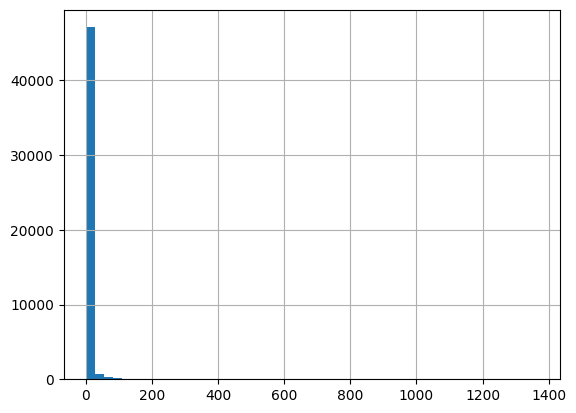

In [7]:
import matplotlib.pyplot as plt
df_freq["Count"].hist(bins = 50)

In [8]:
df_freq["Count"].describe()

,Count
count,48691.000000
mean,5.687889
std,27.717476
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,1365.000000


Most tokens are present once, but the maximum times a token is present is 1365. Most likely, the words that are present that many times are words such as "the", "and", and "is". These aren't very helpful when trying to determine if it's a phishing email.

### Q3.

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions?

In [9]:
phishing_clean = pd.read_parquet("/content/labs/05_PCA/Phishing_clean.parquet")
phishing_clean.head()

,Email Type,new,date,get,please,enron,like,2002,would,one,...,ï¿½ï¿½,safety,yap,ypil,maintain,procedures,tip,elizabeth,leadership,italian
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
from sklearn.model_selection import train_test_split

X = phishing_clean.drop(columns=['Email Type'])
y = phishing_clean['Email Type']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=125)

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lm = LinearRegression(fit_intercept=False).fit(X_train,y_train)
yhat_test = lm.predict(X_test)
yhat_train = lm.predict(X_train)
print('train:', r2_score(yhat_train,y_train) )
print('test:', r2_score(yhat_test,y_test) )

train: 0.6210107280960204
test: -0.00026838432670373


The R^2 on the train set is .6210. The R^2 on the test set is -0.00027

In [12]:
df = pd.DataFrame({'variable':lm.feature_names_in_ , 'value':lm.coef_})
df['abs'] = np.abs(df['value'])
df.sort_values('abs',ascending=False)

,variable,value,abs
710,1997,-1.415784e+13,1.415784e+13
421,1995,1.158467e+13,1.158467e+13
1133,"19,",-1.025713e+13,1.025713e+13
340,2005,-9.773947e+12,9.773947e+12
1146,-0400,-8.062341e+12,8.062341e+12
...,...,...,...
1399,union,2.822876e-04,2.822876e-04
565,east,-2.746582e-04,2.746582e-04
2268,ravages,-1.068115e-04,1.068115e-04
457,due,-6.484985e-05,6.484985e-05


Based on this, numbers are the most common. The model seems to be overfitting. The test set doesn't have a good R^2 value so it's not very helpful.

### Q4.

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

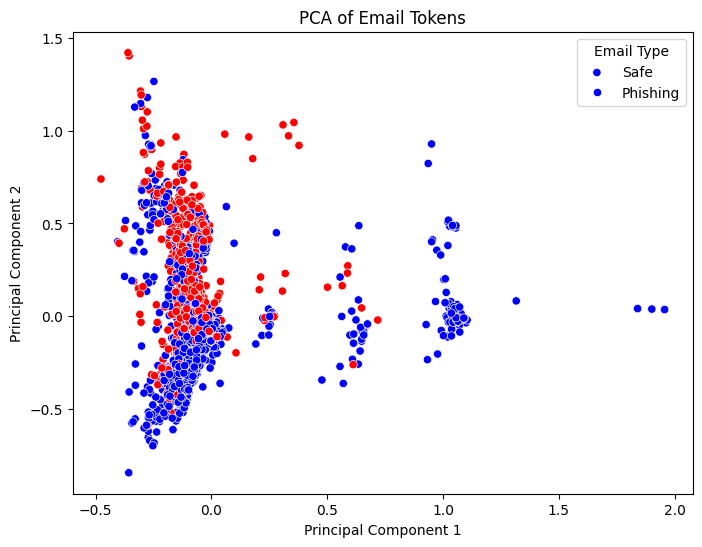

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
Z_train = pca.fit_transform(X_train)
Z_test = pca.transform(X_test)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=Z_test[:, 0],
    y=Z_test[:, 1],
    hue=y_test,
    palette={0:'blue', 1:'red'})

plt.title('PCA of Email Tokens')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Email Type', labels=['Safe', 'Phishing'])
plt.show()

# not sure why my legend has safe and phishing as the same color, I couldn't figure out how to fix it

The phishing dots have first principal components between -.5 and .5. They have higher secondary principal components.

### Q5.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [18]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

pca = PCA(n_components = 2610)
reduction = pca.fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)

lm_k = LinearRegression().fit(Z_train,y_train)
y_hat_test = lm_k.predict(Z_test)
y_hat_train = lm_k.predict(Z_train)

print('train R-squared:', r2_score(y_hat_train,y_train) )
print('test R-squared:', r2_score(y_hat_test,y_test) )

train R-squared: 0.692897536096375
test R-squared: 0.5873905973217184


This performed better than the linear regression. The training and test set r-squared values are closer to each other.

### Q6.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

PCA reduces the number of features which can be helpful if you're using a really large dataset. It also helps with multicolinearity. If features are closely related to each other this can cause multicolinearity. PCA reduces multicolinearity by making principal components that are independent of each other.